In [1]:
import numpy as np
import sklearn
import os
import csv
import cv2
import math
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

total_cameras = 3 #use right and left cameras too

correction = 0.20 #angle correction for left/right cameras
batch_size = 16 
epoch = 10

# chosen model
#CNN_model = "LeNet"
CNN_model = "NVIDIA"
#CNN_model = "comma_ai"
# training dataset 

#path to data
user_path = '/Users/albertoescarlate/Dropbox/Udacity/_SDC_ND013/CARND-AllTerms-projects/CARND-Term1-projects/P3_data'
base_path = user_path + '/data_udacity'

# resizing values 
IMAGE_W_H = 64 # 64 X 64


In [4]:
from random import random

# flip images horizontally
def flip_image(img, angle):
    img = cv2.flip(img, 1)
    angle = angle * -1.0
    return img, angle

def modify_brightness(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    brightness_multiplier = np.random.uniform(0.3, 1.1)
    img[:,:,2] = img[:,:,2]*brightness_multiplier
    img[:,:,2][img[:,:,2]>255] = 255
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

def convert_color_image(img):
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    return img
                       
# crop bottom 25 pixels + crop the image top (scenery above road) + resize it to 64 x 64
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/2.5):shape[0]-20, 0:shape[1]]
    img = cv2.resize(img, (IMAGE_W_H, IMAGE_W_H), interpolation=cv2.INTER_AREA)    
    return img


def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def process_image(img, angle):
    # coinflip image flip  
    img = add_random_shadow(img)
    if np.random.randint(0,1):
        img, angle = flip_image(img, angle)
    img = modify_brightness(img)
    #img = convert_color_image(img)
    img = crop_resize_image(img)
    return img, angle


In [5]:
def load_data(sample):
    path = base_path + '/IMG/'

    name_center = path + sample[0].split('/')[-1]
    name_left = path + sample[1].split('/')[-1]
    name_right = path + sample[2].split('/')[-1]
    
    image_center = cv2.imread(name_center)
    image_left = cv2.imread(name_left)
    image_right = cv2.imread(name_right)
    
    angle_center = float(sample[3]) *(1+ np.random.uniform(-0.10,0.10))
    angle_left = angle_center + correction
    angle_right = angle_center - correction

    return (image_center, image_left, image_right), (angle_center, angle_left, angle_right)
            
def generator(samples, batch_size, total_cameras=3):
    num_samples = len(samples)
    while 1: 
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, angles = [], []
            for batch_sample in batch_samples:
                image, angle = load_data(batch_sample)
                for item in zip(image,angle): #iterate camera images and steering angles
                    aug_image, aug_angle = process_image(item[0], item[1])
                    if abs(aug_angle) > 0.05
                        images.append(aug_image)
                        angles.append(aug_angle)
                
            X_train = np.array(images)
            y_train = np.array(angles)

            yield X_train, y_train
            

In [6]:
def model_comma_ai():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(IMAGE_W_H, IMAGE_W_H, 3), name='Normalization'))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='conv1'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='conv2'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='conv3'))
    model.add(Flatten(name='flat'))
    model.add(Dropout(0.2, name='drop1'))
    model.add(ELU(name='elu1'))
    model.add(Dense(512, activation='elu', name='fully_connected1'))
    model.add(Dropout(0.5, name='drop2'))
    model.add(ELU(name='elu2'))
    model.add(Dense(1, name='output'))
    
    return model

In [7]:
def model_NVIDIA():
    
    drop = 0.7
    activ = 'relu'
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(IMAGE_W_H, IMAGE_W_H, 3), name='Normalization'))
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation=activ, name='Conv1'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation=activ, name='Conv2'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation=activ, name='Conv3'))
    model.add(Convolution2D(64, 3, 3, activation=activ, name='Conv4'))
    model.add(Convolution2D(64, 3, 3, activation=activ, name='Conv5'))
    model.add(Flatten())
    model.add(Dense(1164, activation=activ, name='FC1'))
    #model.add(Dropout(drop, name='drop1'))
    model.add(Dense(100, activation=activ, name='FC2'))
    #model.add(Dropout(drop, name='drop2'))
    model.add(Dense(50, activation=activ, name='FC3'))
    #model.add(Dropout(drop, name='drop3'))
    model.add(Dense(10, activation=activ, name='FC4'))
    #model.add(Dropout(drop, name='drop4'))
    model.add(Dense(1, name='output'))
    
    return model 

In [8]:
def model_LeNet():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(IMAGE_W_H, IMAGE_W_H, 3), name='Normalization'))
    model.add(Convolution2D(6, 5, 5, border_mode="same", activation='elu', name='Conv1'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, border_mode="same", activation='elu', name='Conv2'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120, activation='elu', name='FC1'))
    #model.add(Dropout(0.5, name='drop1'))
    model.add(Dense(84, activation='elu', name='FC2'))
    #model.add(Dropout(0.5, name='drop2'))
    model.add(Dense(1, activation='elu', name='output'))
    model.add(Dropout(0.5, name='drop3'))

    return model

In [9]:
samples = []
path = base_path + '/driving_log.csv'
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)


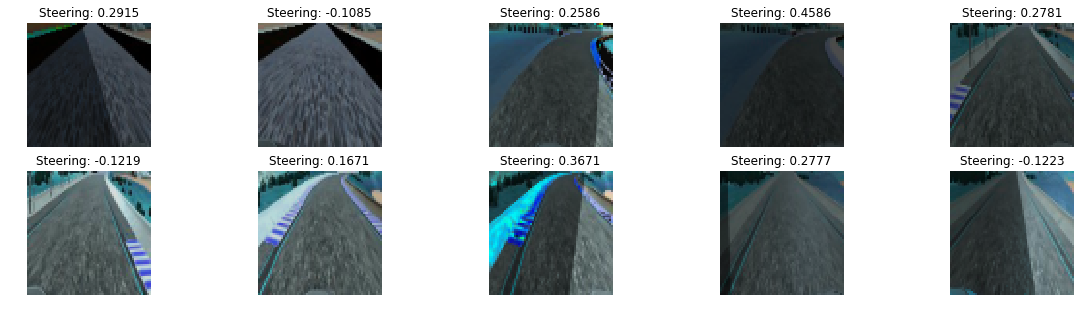

In [16]:
iterator = generator(train_samples, batch_size)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(sample_images[i])
plt.show()

In [17]:
import time, os, fnmatch, shutil

def save_model(model_name):
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H-%M-%S', t)
    model_name = ('model' + model_name  + '_' + timestamp + '.h5')
    
    return model_name

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.layers import Flatten, Lambda, ELU, Cropping2D, Input, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2


if CNN_model == "comma_ai":
    model = model_comma_ai()
else:
    if CNN_model == "LeNet":
        model = model_LeNet() 
    else:
        if CNN_model == "NVIDIA":
            model = model_NVIDIA()
                       
print("Model =", CNN_model)

model.summary()
model.compile(loss='mse', optimizer='Adam')

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(train_samples)*3/batch_size,
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=epoch,
                                     verbose=1)

h5_output = save_model(CNN_model) 
model.save(h5_output)
print("Model saved")

Model = NVIDIA
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 64, 64, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 30, 30, 24)    1824        Normalization[0][0]              
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 13, 13, 36)    21636       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 5, 5, 48)      43248       Conv2[0][0]                      
____________________________________________________________________________

/Users/albertoescarlate/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


653/602 [================================] - 29s - loss: 0.0597 - val_loss: 0.0644
Epoch 2/10
655/602 [================================] - 26s - loss: 0.0513 - val_loss: 0.0452
Epoch 3/10
653/602 [================================] - 24s - loss: 0.0503 - val_loss: 0.0533
Epoch 4/10
654/602 [================================] - 24s - loss: 0.0468 - val_loss: 0.0374
Epoch 5/10
659/602 [================================] - 23s - loss: 0.0330 - val_loss: 0.0279
Epoch 6/10
654/602 [================================] - 21s - loss: 0.0371 - val_loss: 0.0317
Epoch 7/10
653/602 [================================] - 24s - loss: 0.0253 - val_loss: 0.0272
Epoch 8/10
662/602 [================================] - 25s - loss: 0.0268 - val_loss: 0.0242
Epoch 9/10
660/602 [================================] - 26s - loss: 0.0244 - val_loss: 0.0264
Epoch 10/10
649/602 [================================] - 22s - loss: 0.0210 - val_loss: 0.0227
Model saved


batch size = 32
correction 0.2
epochs 10


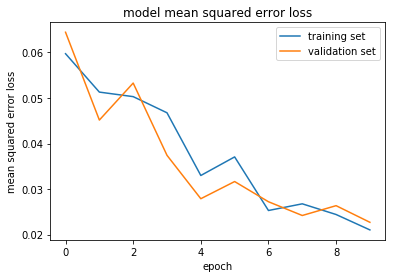

In [20]:
print ('batch size =', batch_size)
print ('correction', correction)
print ('epochs', epoch)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()